In [9]:
%pylab inline
%cd /mnt/home/zzhang/ceph/jemm


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from matplotlib.patches import Patch

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib
/mnt/ceph/users/zzhang/jemm


In [12]:
lod = 24

biomark_names = ['Chamber_ID','SampleName','SampleType','rConc','gene_id','EvaGreen_Type',
        'Ct_Value','Ct_Quality','Ct_Call','Ct_Threshold',
        'Tm_In Range','Tm_Out Range','Tm_Peak Ratio','Tm_Peak Call','Defined_Comments']

def get_biomark_data(file_list, sep='\t'):
    sampleOrder = []
    dfs = []
    for i in file_list:
        df = pd.read_csv(i, skiprows=12, header=None, names=biomark_names, sep=sep)
        sampleOrder += df.SampleName.unique().tolist()
        dfs.append(df)
    ct = pd.concat(dfs)
    return ct, sampleOrder

def reshapeCt(ct, sampleOrder):
    ptable = pd.pivot_table(ct, values='Ct_Value', columns='SampleName', index='gene_id')
    exp_G = ptable.reset_index()
    exp_G.columns.name = None

    exp_G = exp_G[['gene_id'] + sampleOrder]

    # Set the gene_id column as the row name index
    exp_G = exp_G.set_index('gene_id')

    # Transpose so that samples are row names and genes are column names
    exp_G = exp_G.T

    # Get the gene list array from the column names
    gene_list = exp_G.columns

    # Shift the sample names back out of the index to a column so we can rename it to SampleName
    exp_G = exp_G.reset_index()
    exp_G.columns = ['SampleName'] + list(gene_list)

    # Handle missing data and data below the limit of detection (lod)
    lod = 24
    expression_data = exp_G[gene_list].copy()

    # Replace missing data (null, NaN) in expression data with -1
    expression_data[expression_data.isnull()] = -1
    expression_data[expression_data == 999] = -1 # itn_readCtRawDataFromTableFormat where data1_ct[data1_quality == "Fail" & as.numeric(data1_ct) < 999] <- -1

    expression_data[expression_data == -1] = lod # itn_UpdateMissingData where expression_data[expression_data == -1] <- exp$lod[1, 1]

    expression_data = lod - expression_data # itn_generateLog2EXDataFromOrgData where expression_data <- lod - expression_data
    expression_data[expression_data < 0] = 0 # itn_generateLog2EXDataFromOrgData where expression_data[expression_data < 0] <- 0

    log2ex_data = expression_data # itn_generateLog2EXDataFromOrgData wherelog2ex_data <- expression_data

    # Update the org_data in the exp_G dataframe
    exp_G[gene_list] = expression_data


    # Add the group ID annotation as a separate column for PCA, HC and ANOVA
    exp_G['GroupID'] = exp_G['SampleName'].str.split('_').str.get(0)
    return exp_G, gene_list

def expPCA(log2ex_data):
    # The expression_data is Ct values, so they are already log2 (not so for raw RNASeq counts)
    #log2ex_data = expression_data
    # Log transform gene expression data for analysis
    #log2ex_data = log2( exp_G[gene_list] )

    # Convert it to numpy arrays
    X = log2ex_data.values

    # Scaling the values
    X = scale(X, with_std=False)  # center only. the data is already scaled

    pca = PCA(n_components=2)
    X1 = pca.fit(X).transform(X)
    return X1


In [3]:
default_size = pylab.rcParams['figure.figsize']
sns.set_theme()
#sns.reset_orig()  # this will also reset the default fiure size ([6, 4])

pylab.rcParams['figure.figsize'] = [10, 8]


In [4]:
truth = '''CEPN_01	20_2794-T00		neg
CEPN_02	20_2894-T00		neg
CEPN_03	20_3137-T00		neg
CEPN_04	20_0485-T84		pos
CEPN_05	20_2273-T00		neg
CEPN_06	20_2123-T00		neg
CEPN_07	20_0727-T00		neg
CEPN_08	20_2449-T00		neg
CEPN_09	20_1026-T56		pos
CEPN_10	20_1671-T00		neg
CEPN_11	20_2647-T00		neg
CEPN_12	20_1464-T00		neg
CEPN_13	20_1352-T00		neg
CEPN_14	20_1145-T00		neg
CEPN_15	20_0993-T39		pos
CEPN_16	20_2657-T39		pos
CEPN_17	20_1321-T39		pos
CEPN_18	20_1539-T46		pos
CEPN_19	20_1545-T46		pos
CEPN_20	20_1242-T00		neg
CEPN_21	20_3371-T00		neg
CEPN_22	20_1263-T00		neg
CEPN_23	20_1230-T42		pos
CEPN_24	20_1289-T39*		pos
CEPN_25	20_3255-T60		pos
CEPN_26	20_1855-T49		pos
CEPN_27	20_0804-T35		pos
CEPN_28	20_0876-T32		pos
CEPN_29	20_0970-T25		pos
CEPN_30	20_0431-T74		pos
CEPN_31	20_2607-T35		pos
CEPN_32	20_1239-T42		pos
CEPN_33	20_1560-T00		neg
CEPN_34	20_3395-T46		pos
CEPN_35	20_0879-T00		neg
CEPN_36	20_1459-T00		neg
CEPN_37	20_2651-T35		pos
CEPN_38	20_3409-T00		neg
CEPN_39	20_2633-T00		neg
CEPN_40	20_0747-T98		neg
CEPN_41	20_1159-T49		pos
CEPN_42	20_0800-T00		neg
CEPN_43	20_2528-T39		pos
CEPN_44	20_1553-T00		neg
CEPN_45	20_1501-T42		pos
CEPN_46	20_1201-T00		neg
CEPN_47	20_0848-T00		neg
CEPN_48	20_2178-T00		neg
CEPN_49	20_0730-T42		pos
CEPN_50	20_1965-T00		neg
CEPN_51	20_1398-T17		pos
CEPN_52	20_2173-T00		neg
CEPN_53	20_1246-T42		pos
CEPN_54	20_1831-T56		pos
CEPN_55	20_1126-T46		pos
CEPN_56	20_1104-T74		neg
CEPN_57	20_1047-T49		pos
CEPN_58	20_0590-T00		neg
CEPN_59	20_1611-T46		pos
CEPN_60	20_1944-T53		pos
CEPN_61	20_2469-T00		neg
CEPN_62	20_0936-T32		pos'''

In [5]:
header = ['pcrSample', 'sid', 'GroupID']
truth_table = { i:[] for i in header }

for line in truth.split('\n'):
    pcrSample, sid, foo, GroupID = line.split('\t')
    truth_table['pcrSample'].append(pcrSample)
    truth_table['sid'].append(sid)
    truth_table['GroupID'].append(GroupID)
truth_table = pd.DataFrame(truth_table)    

In [6]:
truth_table.head()

,pcrSample,sid,GroupID
0,CEPN_01,20_2794-T00,neg
1,CEPN_02,20_2894-T00,neg
2,CEPN_03,20_3137-T00,neg
3,CEPN_04,20_0485-T84,pos
4,CEPN_05,20_2273-T00,neg


In [13]:


#file_list = ['./data-V7/fluidigm/20210716_Clinical_evaluation_sample_1362651167_result_table_with_adjusted_threshold.csv']
file_list = ['./data-V7/fluidigm/clinical_fluidigm_CT.txt']
ct_orig, sampleOrder = get_biomark_data(file_list)



In [16]:
ct_orig[ct_orig.gene_id == 'Empty'].Ct_Value.describe()

count    3932.0
mean      999.0
std         0.0
min       999.0
25%       999.0
50%       999.0
75%       999.0
max       999.0
Name: Ct_Value, dtype: float64

In [17]:
control_names = ['Empty', 'NTC', 'PC']
controls = ct_orig[(ct_orig.SampleName.isin(control_names))]
ptable = pd.pivot_table(controls, values='Ct_Value', columns='SampleName', index='gene_id')
pd.set_option('precision', 1)
ptable.describe()

SampleName,Empty,NTC,PC
count,56.0,56.0,56.0
mean,999.0,999.0,92.6
std,0.0,0.0,255.3
min,999.0,999.0,5.8
25%,999.0,999.0,8.1
50%,999.0,999.0,12.1
75%,999.0,999.0,15.2
max,999.0,999.0,999.0


In [18]:
pd.set_option('precision', 7)

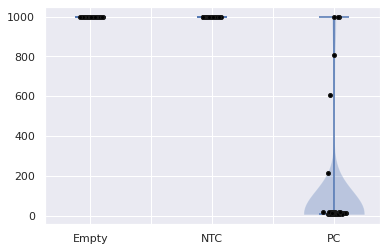

In [19]:
data = []
control_names = ['Empty', 'NTC', 'PC']
for c in control_names:
    data.append(ptable[c].tolist())
    
fig, ax = plt.subplots()
ax.violinplot(data)
#ax.set_xticklabels(['']+control_names)
ax.set_xticklabels(['', 'Empty', '', 'NTC', '', 'PC'])

for i,r in enumerate(data):
    y = r
    x = np.random.normal(i+1, 0.04, len(y))
    plt.plot(x, y, mfc = 'black', mec='k', ms=4, marker="o", linestyle="None")
    
plt.show()

In [20]:
ct = ct_orig.copy()

ct = ct[ct.gene_id != 'Empty']

new_names = []
not_found = []
for name in ct.SampleName.tolist():
    q = truth_table[truth_table.pcrSample == name]
    if len(q) == 0:
        if name in ['Empty', 'NTC', 'PC']:
            #GroupID = 'control'
            GroupID = name
            new_names.append(GroupID + '_' + name)
        else:
            print('Could not find ' + name)
    elif len(q) > 1:
        print('To many results for ' + name)
    else:
        GroupID = q.GroupID.tolist()[0]
        new_names.append(GroupID + '_' + name)
        
        
ct.SampleName = new_names
sampleOrder = ct.SampleName.unique().tolist()

#ctNoControls = ct[~(ct.SampleName.str.startswith('control'))]
#sampleOrderNoControls = [i for i in sampleOrder if not 'control' in i]

ctNoControls = ct[~(ct.SampleName.isin(['Empty_Empty', 'NTC_NTC', 'PC_PC']))]
sampleOrderNoControls = [i for i in sampleOrder if not i in ['Empty_Empty', 'NTC_NTC', 'PC_PC']]

ctP = ct[~(ct.SampleName.isin(['Empyt_Empty', 'NTC_NTC']))]
sampleOrderP = [i for i in sampleOrder if not i in ['Empty_Empty', 'NTC_NTC']]


In [21]:


exp_G, gene_list = reshapeCt(ctNoControls, sampleOrderNoControls)
log2ex_data = expression_data = exp_G[gene_list]
X1 = expPCA(log2ex_data)

# Data range for the decision boundary line
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1



In [23]:
exp_G

,SampleName,ATP6V0B_longP,ATP6V0B_shortP,EPSTI1_longP,EPSTI1_shortP,GALNS_longP,GALNS_shortP,HK-ACTB,HMGN2_longP,HMGN2_shortP,...,SESN3_shortP,SNHG32_longP,SNHG32_shortP,TUBA8_longP,TUBA8_shortP,U91328.1_longP,U91328.1_shortP,ZFYVE26_longP,ZFYVE26_shortP,GroupID
0,neg_CEPN_33,14.4696732,7.3691600,10.6937758,13.2523246,9.2801812,9.8759887,16.1669736,12.0358785,15.0564709,...,14.9006920,11.3912994,12.4523777,9.3579491,0.0000000,0.0000000,6.4399232,10.7802102,8.0788062,neg
1,pos_CEPN_25,14.9704918,12.7273164,12.9949013,16.0181149,9.8110168,10.3897758,17.0539109,12.1438466,15.3353688,...,14.9741020,12.0644018,13.2228726,11.1624605,5.7855727,6.0872336,7.2906351,10.2150207,8.9250593,pos
2,pos_CEPN_17,15.1710643,11.9720848,13.5666245,16.4812731,10.4376375,11.0007923,17.2902802,13.0962125,16.2608376,...,13.4933559,12.3147139,13.5411148,10.4823417,5.9313445,5.2445670,9.0784112,11.0613709,8.9020600,pos
3,pos_CEPN_09,15.2933489,11.3962602,13.8670642,16.2950057,10.1071987,10.4288973,17.0509013,12.6158630,16.0480934,...,14.6768529,12.4359712,13.1725240,10.0415187,4.9066532,5.3403783,8.7045679,11.0606187,9.4279155,pos
4,neg_CEPN_56,15.5949891,13.0989230,11.8708851,14.5979094,10.2903074,10.3867048,16.7694543,12.1549500,15.4593019,...,15.2142303,11.8674803,12.8402385,9.2061507,5.2439801,3.2341095,8.6118840,10.0940720,7.6569602,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,neg_CEPN_13,14.2573068,10.6543125,11.0533953,13.6023876,9.1821259,10.1275777,17.0982843,11.6038730,15.0260991,...,15.0218775,11.7588995,13.0374632,9.2953752,2.1819893,4.8864818,4.8569147,10.0034047,8.6162811,neg
58,pos_CEPN_60,13.0498648,10.6081978,12.0762334,14.5162013,8.4958950,9.4173713,16.2870420,11.7663047,14.9822884,...,12.5131013,11.4794882,12.3987202,8.7686063,2.3204561,0.0000000,6.8197251,9.4409276,8.6445626,pos
59,neg_CEPN_05,15.2929568,10.0863799,11.9462736,14.3749114,10.2115056,11.0499962,18.0156758,12.6871333,15.5877349,...,14.8436367,11.9817360,13.1403827,9.8802970,5.1315030,3.9763488,7.9058391,9.8603144,8.0303382,neg
60,neg_CEPN_52,13.4369720,8.7684276,8.7248362,11.9025674,8.2726864,9.0205483,16.4098979,11.1777991,14.4423293,...,14.9644066,11.1801414,11.8714147,8.5891792,3.3241581,4.2311970,6.2154265,9.2507289,7.8553509,neg


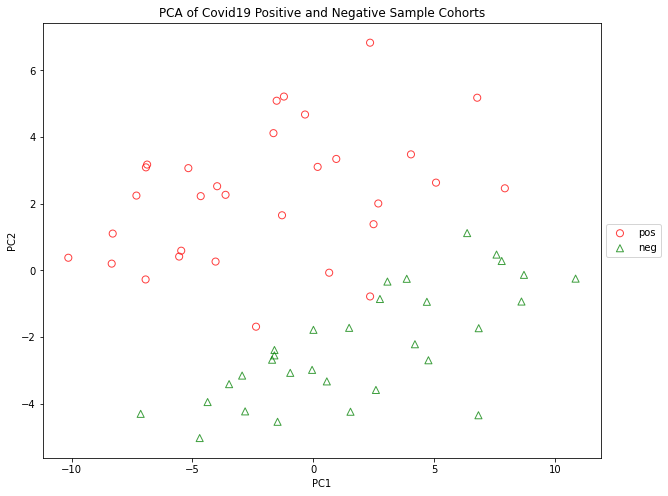

In [22]:
sns.reset_orig()  # this will also reset the default fiure size ([6, 4])

pylab.rcParams['figure.figsize'] = [10, 8]



y = exp_G.GroupID
y_unique = list(reversed(y.unique().tolist()))

markers = {
    'pos': ('red', 'o', 100, 'none'),
    'neg': ('green', '^', 100, 'none')
}

for i in y_unique:
    plt.scatter(X1[ np.array(y==i), 0 ], X1[ np.array(y==i), 1], label=i,
                edgecolors=markers[i][0], marker=markers[i][1], s=50, facecolors='none', linewidth=1, alpha=0.75)
plt.title('PCA of Covid19 Positive and Negative Sample Cohorts')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

